# Analysing neural network models


This tutorial includes:

- PCA analysis of neural activity
- Lesioning of the network
- Fixed-Point analysis using the FixedPointFinder package

In [37]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from scipy.stats import entropy
import matplotlib.pyplot as plt
from tqdm import tqdm

# 定义RNN模型
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(RNNModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        # 使用LSTM，也可以改为 nn.RNN 或 nn.GRU
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        # 对每个时间步的隐藏状态进行线性变换得到输出
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        # 初始化隐藏状态和细胞状态
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        # 前向传播LSTM
        out, (hn, cn) = self.rnn(x, (h0, c0))  # out: (batch_size, seq_length, hidden_size)
        
        # 对每个时间步的输出进行线性变换
        outputs = self.fc(out)  # outputs: (batch_size, seq_length, output_size)
        
        # 收集每个时间步的隐藏状态
        hidden_states = out  # (batch_size, seq_length, hidden_size)
        
        return outputs, hidden_states

# 计算互信息的函数
def compute_mutual_information(X, T, num_bins=30):
    """
    计算 I(X; T) 的近似值。

    参数：
    - X: 输入数据，形状为 (num_samples, seq_length, input_size)
    - T: 隐藏状态，形状为 (num_samples, seq_length, hidden_size)
    - num_bins: 用于离散化的bin数量
    """
    num_samples, seq_length, hidden_size = T.shape
    I_XT = []

    for t in range(seq_length):
        I_XT_t = 0
        # 获取第 t 个时间步的隐藏状态
        T_t = T[:, t, :]  # (num_samples, hidden_size)
        # 获取第 t 个时间步的输入
        X_t = X[:, :t+1, :]  # (num_samples, input_size)
        # print(X.shape,X_t.shape, X_t.shape[2]*X_t.shape[1])
        X_t = X_t.reshape(X_t.shape[0], X_t.shape[2]*X_t.shape[1])
        # print(X.shape,X_t.shape)
        for i in range(hidden_size):
            # 离散化隐藏状态的第 i 个神经元
            t_i = T_t[:, i].detach().cpu().numpy()
            t_bins = np.histogram_bin_edges(t_i, bins=num_bins)
            t_digitized = np.digitize(t_i, bins=t_bins)
            
            # 对于输入的每个维度，同样离散化
            mutual_info = 0
            for j in range(X_t.shape[1]):
                x_j = X_t[:, j].detach().cpu().numpy()
                x_bins = np.histogram_bin_edges(x_j, bins=num_bins)
                x_digitized = np.digitize(x_j, bins=x_bins)
                
                # 计算联合概率分布和边缘概率分布
                joint_hist, _, _ = np.histogram2d(x_digitized, t_digitized, bins=num_bins)
                joint_prob = joint_hist / num_samples
                x_marginal = np.sum(joint_prob, axis=1)
                t_marginal = np.sum(joint_prob, axis=0)
                
                # 计算互信息
                joint_prob += 1e-12
                x_marginal += 1e-12
                t_marginal += 1e-12
                mi = np.sum(joint_prob * (np.log(joint_prob) - np.log(np.outer(x_marginal, t_marginal))))
                mutual_info += mi
            # 取输入维度的平均互信息
            mutual_info /= X_t.shape[1]
            I_XT_t += mutual_info
        # 取隐藏维度的平均互信息
        I_XT_t /= hidden_size
        I_XT.append(I_XT_t)
    return I_XT  # 返回每个时间步的 I(X; T_t)

def compute_mutual_information_TY(T, Y, num_bins=30):
    """
    计算 I(T; Y) 的近似值。

    参数：
    - T: 隐藏状态，形状为 (num_samples, seq_length, hidden_size)
    - Y: 标签，形状为 (num_samples, seq_length)
    - num_bins: 用于离散化的bin数量
    """
    num_samples, seq_length, hidden_size = T.shape
    I_TY = []
    print('seq_length', seq_length)

    for t in range(seq_length):
        I_TY_t = 0
        # 获取第 t 个时间步的隐藏状态
        T_t = T[:, t, :]  # (num_samples, hidden_size)
        # 获取第 t 个时间步的标签
        Y_t = Y[:, t]  # (num_samples,)
        unique_Y = np.unique(Y_t.detach().cpu().numpy())
        num_classes = unique_Y.size
        for i in range(hidden_size):
            # 离散化隐藏状态的第 i 个神经元
            t_i = T_t[:, i].detach().cpu().numpy()
            t_bins = np.histogram_bin_edges(t_i, bins=num_bins)
            t_digitized = np.digitize(t_i, bins=t_bins)
            
            y = Y_t.detach().cpu().numpy()
            # 计算联合概率分布和边缘概率分布
            joint_hist, _, _ = np.histogram2d(t_digitized, y, bins=[num_bins, num_classes])
            joint_prob = joint_hist / num_samples
            t_marginal = np.sum(joint_prob, axis=1)
            y_marginal = np.sum(joint_prob, axis=0)
            
            # 计算互信息
            joint_prob += 1e-12
            t_marginal += 1e-12
            y_marginal += 1e-12
            mi = np.sum(joint_prob * (np.log(joint_prob) - np.log(np.outer(t_marginal, y_marginal))))
            I_TY_t += mi
        # 取隐藏维度的平均互信息
        I_TY_t /= hidden_size
        I_TY.append(I_TY_t)
    return I_TY  # 返回每个时间步的 I(T_t; Y_t)

# 示例训练过程，计算每个时间步的 I(X; T_t) 和 I(T_t; Y_t)
def train_and_compute_information(net, dataloader, criterion, optimizer, epochs, num_bins=30):
    """
    在训练过程中，每个epoch结束后，计算每个时间步的互信息。

    返回：
    - I_XT_list: 列表，包含每个epoch的 I(X; T_t)
    - I_TY_list: 列表，包含每个epoch的 I(T_t; Y_t)
    """
    I_XT_list = []
    I_TY_list = []
    
    for epoch in tqdm(range(epochs), desc="Training"):
        net.train()
        for X_batch, Y_batch in dataloader:
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)
            optimizer.zero_grad()
            outputs, hidden_states = net(X_batch)
            # 将 outputs 变形为 (batch_size * seq_length, output_size)
            outputs = outputs.reshape(-1, outputs.size(-1))
            Y_batch = Y_batch.reshape(-1)
            loss = criterion(outputs, Y_batch)
            loss.backward()
            optimizer.step()
        
        # 在每个epoch结束后，计算每个时间步的互信息
        net.eval()
        all_X = []
        all_T = []
        all_Y = []
        with torch.no_grad():
            for X_batch, Y_batch in dataloader:
                X_batch = X_batch.to(device)
                Y_batch = Y_batch.to(device)
                outputs, hidden_states = net(X_batch)
                all_X.append(X_batch.cpu())
                all_T.append(hidden_states.cpu())
                all_Y.append(Y_batch.cpu())
            all_X = torch.cat(all_X, dim=0)  # (num_samples, seq_length, input_size)
            all_T = torch.cat(all_T, dim=0)  # (num_samples, seq_length, hidden_size)
            all_Y = torch.cat(all_Y, dim=0)  # (num_samples, seq_length)

            print(all_X.shape, all_T.shape, all_Y.shape)
            
            I_XT = compute_mutual_information(all_X, all_T, num_bins)
            I_TY = compute_mutual_information_TY(all_T, all_Y, num_bins)
            I_XT_list.append(I_XT)
            I_TY_list.append(I_TY)
    
    return I_XT_list, I_TY_list

# 绘制信息平面
def plot_information_plane(I_XT_list, I_TY_list, seq_length):
    """
    绘制每个时间步的信息平面。

    参数:
    - I_XT_list: 每个epoch的 I(X; T_t)
    - I_TY_list: 每个epoch的 I(T_t; Y_t)
    - seq_length: 序列长度
    """
    epochs = len(I_XT_list)
    plt.figure(figsize=(10, 6))
    for epoch in range(epochs):
        plt.scatter(I_XT_list[epoch], I_TY_list[epoch], label=f'Epoch {epoch+1}')
    plt.xlabel('I(X; T_t)')
    plt.ylabel('I(T_t; Y_t)')
    plt.title('信息平面')
    plt.legend()
    plt.grid(True)
    plt.show()

# 示例用法
# if __name__ == "__main__":
#     # 设置设备
#     device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
#     # 创建示例数据集
#     from torch.utils.data import TensorDataset, DataLoader

#     num_samples = 1000
#     seq_length = 100
#     input_size = 10
#     hidden_size = 50
#     output_size = 2  # 二分类
#     epochs = 5
#     batch_size = 32

#     # 生成随机数据
#     X = torch.randn(num_samples, seq_length, input_size)
#     # 随机生成标签，每个时间步都有一个标签
#     Y = torch.randint(0, output_size, (num_samples, seq_length))

#     dataset = TensorDataset(X, Y)
#     dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

#     # 初始化网络、损失函数和优化器
#     net = RNNModel(input_size, hidden_size, output_size).to(device)
#     criterion = nn.CrossEntropyLoss()
#     optimizer = optim.Adam(net.parameters(), lr=0.001)

#     # 训练并计算信息量
#     I_XT_list, I_TY_list = train_and_compute_information(net, dataloader, criterion, optimizer, epochs, num_bins=30)

#     # 绘制信息平面
#     # 由于每个时间步都有一个 I(X; T_t) 和 I(T_t; Y_t)，我们可以选择绘制某个时间步的结果
#     # 例如，绘制第50个时间步的结果
#     time_step = 99
#     I_XT_time = [epoch_I_XT[time_step] for epoch_I_XT in I_XT_list]
#     I_TY_time = [epoch_I_TY[time_step] for epoch_I_TY in I_TY_list]

#     plt.figure(figsize=(8, 6))
#     plt.plot(I_XT_time, I_TY_time, marker='o')
#     for i in range(len(I_XT_time)):
#         plt.text(I_XT_time[i], I_TY_time[i], str(i+1))
#     plt.xlabel(f'I(X; T_{time_step})')
#     plt.ylabel(f'I(T_{time_step}; Y_{time_step})')
#     plt.title(f'时间步 {time_step} 的信息平面')
#     plt.grid(True)
#     plt.show()


### E-I recurrent network

 We start with the E-I recurrent network with **excitatory and inhibitory neurons** which we got introduced to in week 4 tutorial.


In [52]:
import torch
import torch.nn as nn
from torch.nn import init
from torch.nn import functional as F
import math
from matplotlib.lines import Line2D

In [53]:
# @title E-I recurrent network

class EIRecLinear(nn.Module):

    r"""Recurrent E-I Linear transformation.

    This module implements a linear transformation with recurrent E-I dynamics,
    where part of the units are excitatory and the rest are inhibitory.

    Args:
        hidden_size: int, the number of units in the layer.
        e_prop: float between 0 and 1, the proportion of excitatory units.
        bias: bool, if True, adds a learnable bias to the output.
    """

    __constants__ = ['bias', 'hidden_size', 'e_prop']

    def __init__(self, hidden_size, e_prop, bias=True):
        super().__init__()
        self.hidden_size = hidden_size
        self.e_prop = e_prop
        self.e_size = int(e_prop * hidden_size) # Number of excitatory units
        self.i_size = hidden_size - self.e_size # Number of inhibitory units

        # Weight matrix for the recurrent connections
        self.weight = nn.Parameter(torch.Tensor(hidden_size, hidden_size))

        # Create a mask to define the E-I interactions
        # The mask has ones for E to E/I and negative ones for I to E/I, except the diagonal
        mask = np.tile([1]*self.e_size+[-1]*self.i_size, (hidden_size, 1))
        np.fill_diagonal(mask, 0)
        self.mask = torch.tensor(mask, dtype=torch.float32)

        # Optionally add a bias term
        if bias:
            self.bias = nn.Parameter(torch.Tensor(hidden_size))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self):
        # Initialize weights and biases
        init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        # Scale the weights for the excitatory neurons
        self.weight.data[:, :self.e_size] /= (self.e_size/self.i_size)

        # Initialize biases
        if self.bias is not None:
            fan_in, _ = init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in)
            init.uniform_(self.bias, -bound, bound)

    def effective_weight(self):
        # Apply the mask to the absolute values of the weights to get the effective weight
        # This ensures that weights from excitatory neurons are positive,
        # and weights from inhibitory neurons are negative.
        return F.relu(self.weight) * self.mask

    def forward(self, input):
        # Apply the linear transformation using the effective weights and biases
        # The weights used are non-negative due to the absolute value in effective_weight.
        return F.linear(input, self.effective_weight(), self.bias)

class EIRNN(nn.Module):
    """E-I RNN.

    Reference:
        Song, H.F., Yang, G.R. and Wang, X.J., 2016.
        Training excitatory-inhibitory recurrent neural networks
        for cognitive tasks: a simple and flexible framework.
        PLoS computational biology, 12(2).

    Args:
        input_size: Number of input neurons
        hidden_size: Number of hidden neurons
    """

    def __init__(self, input_size, hidden_size, dt=None,
                 e_prop=0.8, sigma_rec=0, **kwargs):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.e_size = int(hidden_size * e_prop)
        self.i_size = hidden_size - self.e_size
        self.num_layers = 1
        self.tau = 100
        if dt is None:
            alpha = 1
        else:
            alpha = dt / self.tau
        self.alpha = alpha
        self.oneminusalpha = 1 - alpha
        self._sigma_rec = np.sqrt(2 * alpha) * sigma_rec

        self.input2h = nn.Linear(input_size, hidden_size)
        self.h2h = EIRecLinear(hidden_size, e_prop=0.8)

    def init_hidden(self, input):
        batch_size = input.shape[1]
        return torch.zeros(batch_size, self.hidden_size).to(input.device)  # Single tensor for hidden state

    def recurrence(self, input, hidden):
        """Recurrence helper with a single hidden tensor."""
        total_input = self.input2h(input) + self.h2h(hidden)
        state = hidden * self.oneminusalpha + total_input * self.alpha
        state += self._sigma_rec * torch.randn_like(state)
        output = torch.relu(state)
        return output

    def forward(self, input, hidden=None):
        """Propagate input through the network."""
        if hidden is None:
            hidden = self.init_hidden(input)

        output = []
        for i in range(input.size(0)):
            hidden = self.recurrence(input[i], hidden)
            output.append(hidden)
        output = torch.stack(output, dim=0)
        return output, hidden

class Net(nn.Module):
    """Recurrent network model.

    Args:
        input_size: int, input size
        hidden_size: int, hidden size
        output_size: int, output size
        rnn: str, type of RNN, lstm, rnn, ctrnn, or eirnn
    """
    def __init__(self, input_size, hidden_size, output_size, **kwargs):
        super().__init__()

        # Excitatory-inhibitory RNN
        self.input_size = input_size
        self.rnn = EIRNN(input_size, hidden_size, **kwargs)
        self.fc = nn.Linear(self.rnn.e_size, output_size)

    def forward(self, x):
        rnn_activity, _ = self.rnn(x)
        rnn_e = rnn_activity[:, :, :self.rnn.e_size]
        out = self.fc(rnn_e)
        return out, rnn_activity


In [ ]:
import torch
import torch.nn as nn

class LeakyRNN(nn.Module):
    """
    Leaky RNN（泄漏递归神经网络）。

    参数:
        input_size: 输入神经元数量。
        hidden_size: 隐藏神经元数量。
        dt: 离散化时间步（单位：ms）。
            如果为 None，则 `dt` 默认为时间常数 tau。

    输入:
        input: 形状为 (seq_len, batch, input_size) 的张量，表示输入序列。
        hidden: 形状为 (batch, hidden_size) 的张量，初始隐藏状态。
            如果为 None，则通过 self.init_hidden() 初始化。

    输出:
        output: 形状为 (seq_len, batch, hidden_size) 的张量，表示隐藏层的输出序列。
        hidden: 形状为 (batch, hidden_size) 的张量，表示最终隐藏状态。
    """

    def __init__(self, input_size, hidden_size, dt=None, **kwargs):
        super().__init__()
        self.input_size = input_size  # 输入特征数量
        self.hidden_size = hidden_size  # 隐藏层神经元数量
        self.tau = 100  # 时间常数
        if dt is None:
            alpha = 1  # 如果未指定 dt，则步长比例为 1
        else:
            alpha = dt / self.tau  # 计算步长比例
        self.alpha = alpha  # 存储步长比例

        self.input2h = nn.Linear(input_size, hidden_size)  # 输入到隐藏层的线性映射
        self.h2h = nn.Linear(hidden_size, hidden_size)  # 隐藏层到隐藏层的线性映射

    def init_hidden(self, input_shape):
        """
        初始化隐藏状态。

        参数:
            input_shape: 输入张量的形状。

        返回:
            初始化为零的隐藏状态张量，形状为 (batch_size, hidden_size)。
        """
        batch_size = input_shape[1]  # 从输入形状中获取批量大小
        return torch.zeros(batch_size, self.hidden_size)  # 初始化为全零张量

    def recurrence(self, input, hidden):
        """
        执行一次时间步的网络更新。

        参数:
            input: 形状为 (batch, input_size) 的张量，表示当前时间步的输入。
            hidden: 形状为 (batch, hidden_size) 的张量，表示当前时间步的隐藏状态。

        返回:
            h_new: 形状为 (batch, hidden_size) 的张量，表示下一时间步的隐藏状态。
        """
        h_new = torch.relu(self.input2h(input) + self.h2h(hidden))  # 当前时间步的隐藏状态
        h_new = hidden * (1 - self.alpha) + h_new * self.alpha  # 添加泄漏动态
        return h_new

    def forward(self, input, hidden=None):
        """
        通过网络传播输入。

        参数:
            input: 形状为 (seq_len, batch, input_size) 的张量，输入序列。
            hidden: 初始隐藏状态。

        返回:
            output: 形状为 (seq_len, batch, hidden_size) 的张量，隐藏层的输出序列。
            hidden: 形状为 (batch, hidden_size) 的张量，最终隐藏状态。
        """
        # 如果未提供隐藏状态，则初始化
        if hidden is None:
            hidden = self.init_hidden(input.shape).to(input.device)

        output = []  # 用于存储每个时间步的隐藏层输出
        steps = range(input.size(0))  # 获取时间步数
        for i in steps:
            hidden = self.recurrence(input[i], hidden)  # 更新隐藏状态
            output.append(hidden)  # 保存当前时间步的隐藏状态

        # 将所有时间步的输出堆叠为张量
        output = torch.stack(output, dim=0)  # (seq_len, batch, hidden_size)
        return output, hidden


class RNNNet(nn.Module):
    """
    带输出层的递归网络模型。

    参数:
        input_size: int, 输入大小。
        hidden_size: int, 隐藏层大小。
        output_size: int, 输出大小。

    输入:
        x: 形状为 (seq_len, batch, input_size) 的输入序列。

    输出:
        out: 形状为 (seq_len, batch, output_size) 的张量，表示最终的网络输出。
        rnn_output: 形状为 (seq_len, batch, hidden_size) 的张量，表示隐藏层的输出序列。
    """
    def __init__(self, input_size, hidden_size, output_size, **kwargs):
        super().__init__()

        # 使用 Leaky RNN 作为基础递归网络
        self.rnn = LeakyRNN(input_size, hidden_size, **kwargs)

        # 输出层，用于从隐藏层映射到输出
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        rnn_output, _ = self.rnn(x)  # 获取隐藏层输出序列
        out = self.fc(rnn_output)  # 将隐藏层输出映射到最终输出
        return out, rnn_output


In [175]:
# @title Generating dataset from a perceptual decision making task
! git clone https://github.com/neurogym/neurogym.git
%cd neurogym/
! pip install -e .

/bin/sh: 1: git: not found
[Errno 2] No such file or directory: 'neurogym/'
/houqingfan/neurogym/neurogym
ERROR: File "setup.py" or "setup.cfg" not found. Directory cannot be installed in editable mode: /houqingfan/neurogym/neurogym


In [56]:
# @title import the task from the neurogym library

import neurogym as ngym

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib.font_manager")

# # Environment
# task = 'PerceptualDecisionMaking-v0'
# timing = {
#     'fixation': ('choice', (50, 100, 200, 400)),
#     'stimulus': ('choice', (100, 200, 400, 800)),
# }


# kwargs = {'dt': 20, 'timing': timing}
# seq_len = 100

# # Make supervised dataset
# dataset = ngym.Dataset(task, env_kwargs=kwargs, batch_size=128,
#                        seq_len=seq_len)


task = 'DelayComparison-v0'
# 设定实验任务相关条件
# delay时长为200ms或400ms或800ms或1600ms或3200ms
# 固定的反应时长为500ms
# 一个时间点对应100ms
# 序列长度为100个时间点（即10000ms）
timing = {'delay': ('choice', [200, 400, 800, 1600, 3200]),
          'response': ('constant', 500)
         }
kwargs = {'dt': 100, 'timing': timing}
seq_len = 100

# 构建任务数据集，传入上述相关参数
# batch_size=16代表生成16个序列
dataset = ngym.Dataset(task, env_kwargs=kwargs, batch_size=16,
                       seq_len=seq_len)



# A sample environment from dataset
env = dataset.env

# Network input and output size
input_size = env.observation_space.shape[0]
output_size = env.action_space.n

/opt/conda/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:69: UserWarning: WARN: Agent's minimum action space value is -infinity. This is probably too low.
  logger.warn(
/opt/conda/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:73: UserWarning: WARN: Agent's maximum action space value is infinity. This is probably too high
  logger.warn(
/opt/conda/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:97: UserWarning: WARN: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  logger.warn(


In [59]:
# @title Train the network on the decision making task

import torch
import torch.optim as optim
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib.font_manager")

# Assuming Net is defined somewhere and dataset() function is defined
# Assuming input_size and output_size are also defined

# Instantiate the network
hidden_size = 50
net = Net(input_size=input_size, hidden_size=hidden_size,
          output_size=output_size, dt=env.dt, sigma_rec=0.15)
print(net)

# Use Adam optimizer
optimizer = optim.Adam(net.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

loss_values = []  # List to store loss values
running_loss = 0.0
print_step = 200

num_hidden_layers = 5
num_bins=30

activity_save = []

I_XT_list = []
I_TY_list = []
for i in tqdm(range(200), desc="Processing"):
    inputs, labels_org = dataset()
    inputs = torch.from_numpy(inputs).type(torch.float)
    labels = torch.from_numpy(labels_org.flatten()).type(torch.long)
    labels_org = torch.from_numpy(labels_org)
    # print(labels_org.shape)
    net.train()
    # Zero the gradient buffers
    optimizer.zero_grad()

    # Forward pass
    output, activity = net(inputs)
    # print(activity.shape)

    activity_save.append(activity[0,:,:].view(16,-1).detach().numpy())
    # print(output.shape, activity.shape)
    output = output.view(-1, output_size)
    # print(output.shape)

    # Compute loss
    loss = criterion(output, labels)

    # Backward pass
    loss.backward()

    # Update weights
    optimizer.step()

    # Update running loss
    running_loss += loss.item()
    if i % print_step == (print_step - 1):
        average_loss = running_loss / print_step
        print('Step {}, Loss {:0.4f}'.format(i+1, average_loss))
        loss_values.append(average_loss)  # Append average loss here
        running_loss = 0.0

    if i  % 100 = 0:
    
        # 在每个epoch结束后，计算每个时间步的互信息
        net.eval()
        all_X = []
        all_T = []
        all_Y = []
        with torch.no_grad():
            X_batch = inputs
            Y_batch = labels_org
            outputs, hidden_states = net(X_batch)
            all_X.append(X_batch.cpu())
            all_T.append(hidden_states.cpu())
            all_Y.append(Y_batch.cpu())
            # torch.Size([1000, 100, 10]) torch.Size([1000, 100, 50]) torch.Size([1000, 100])
            all_X = torch.cat(all_X, dim=0)  # (num_samples, seq_length, input_size)
            all_T = torch.cat(all_T, dim=0)  # (num_samples, seq_length, hidden_size)
            all_Y = torch.cat(all_Y, dim=0)  # (num_samples, seq_length)
    
            all_X = all_X.permute(1, 0, 2)
            all_Y = all_Y.permute(1, 0)
            all_T = all_T.permute(1, 0, 2)
            # torch.Size([100, 16, 3]) torch.Size([100, 16]) torch.Size([100, 16, 50])
            print(all_X.shape, all_Y.shape, all_T.shape)
    
            I_XT = compute_mutual_information(all_X, all_T, num_bins)
            I_TY = compute_mutual_information_TY(all_T, all_Y, num_bins)
            I_XT_list.append(I_XT)
            I_TY_list.append(I_TY)







# activity_save = np.stack(activity_save, axis=0)
# hidden_activations = activity_save

# # 计算熵
# entropies = compute_layer_entropy(hidden_activations, num_bins=30, aggregation='average')

# # 绘制结果
# plot_entropy(entropies)

Net(
  (rnn): EIRNN(
    (input2h): Linear(in_features=2, out_features=50, bias=True)
    (h2h): EIRecLinear()
  )
  (fc): Linear(in_features=40, out_features=3, bias=True)
)


Processing: 100%|██████████| 200/200 [00:02<00:00, 81.08it/s]

Step 200, Loss 0.1938


In [ ]:
# @title Train the network on the decision making task

import torch
import torch.optim as optim
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib.font_manager")

# Assuming Net is defined somewhere and dataset() function is defined
# Assuming input_size and output_size are also defined

# Instantiate the network
hidden_size = 50
net = RNNNet(input_size=input_size, hidden_size=hidden_size,
          output_size=output_size, dt=env.dt, sigma_rec=0.15)
print(net)

# Use Adam optimizer
optimizer = optim.Adam(net.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

loss_values = []  # List to store loss values
running_loss = 0.0
print_step = 200

num_hidden_layers = 5
num_bins=30

activity_save = []

I_XT_list_lr = []
I_TY_list_lr = []
for i in tqdm(range(200), desc="Processing"):
    inputs, labels_org = dataset()
    inputs = torch.from_numpy(inputs).type(torch.float)
    labels = torch.from_numpy(labels_org.flatten()).type(torch.long)
    labels_org = torch.from_numpy(labels_org)
    # print(labels_org.shape)
    net.train()
    # Zero the gradient buffers
    optimizer.zero_grad()

    # Forward pass
    output, activity = net(inputs)
    # print(activity.shape)

    activity_save.append(activity[0,:,:].view(16,-1).detach().numpy())
    # print(output.shape, activity.shape)
    output = output.view(-1, output_size)
    # print(output.shape)

    # Compute loss
    loss = criterion(output, labels)

    # Backward pass
    loss.backward()

    # Update weights
    optimizer.step()

    # Update running loss
    running_loss += loss.item()
    if i % print_step == (print_step - 1):
        average_loss = running_loss / print_step
        print('Step {}, Loss {:0.4f}'.format(i+1, average_loss))
        loss_values.append(average_loss)  # Append average loss here
        running_loss = 0.0

    if i  % 100 = 0:
    
        # 在每个epoch结束后，计算每个时间步的互信息
        net.eval()
        all_X = []
        all_T = []
        all_Y = []
        with torch.no_grad():
            X_batch = inputs
            Y_batch = labels_org
            outputs, hidden_states = net(X_batch)
            all_X.append(X_batch.cpu())
            all_T.append(hidden_states.cpu())
            all_Y.append(Y_batch.cpu())
            # torch.Size([1000, 100, 10]) torch.Size([1000, 100, 50]) torch.Size([1000, 100])
            all_X = torch.cat(all_X, dim=0)  # (num_samples, seq_length, input_size)
            all_T = torch.cat(all_T, dim=0)  # (num_samples, seq_length, hidden_size)
            all_Y = torch.cat(all_Y, dim=0)  # (num_samples, seq_length)
    
            all_X = all_X.permute(1, 0, 2)
            all_Y = all_Y.permute(1, 0)
            all_T = all_T.permute(1, 0, 2)
            # torch.Size([100, 16, 3]) torch.Size([100, 16]) torch.Size([100, 16, 50])
            print(all_X.shape, all_Y.shape, all_T.shape)
    
            I_XT = compute_mutual_information(all_X, all_T, num_bins)
            I_TY = compute_mutual_information_TY(all_T, all_Y, num_bins)
            I_XT_list_lr.append(I_XT)
            I_TY_list_lr.append(I_TY)







# activity_save = np.stack(activity_save, axis=0)
# hidden_activations = activity_save

# # 计算熵
# entropies = compute_layer_entropy(hidden_activations, num_bins=30, aggregation='average')

# # 绘制结果
# plot_entropy(entropies)

In [58]:
task = 'DelayComparison-v0'
# 设定实验任务相关条件
# delay时长为200ms或400ms或800ms或1600ms或3200ms
# 固定的反应时长为500ms
# 一个时间点对应100ms
# 序列长度为100个时间点（即10000ms）
timing = {'delay': ('choice', [200, 400, 800, 1600, 3200]),
          'response': ('constant', 500)
         }
kwargs = {'dt': 100, 'timing': timing}
seq_len = 100

# 构建任务数据集，传入上述相关参数
# batch_size=16代表生成16个序列
dataset = ngym.Dataset(task, env_kwargs=kwargs, batch_size=16,
                       seq_len=seq_len)

/opt/conda/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:69: UserWarning: WARN: Agent's minimum action space value is -infinity. This is probably too low.
  logger.warn(
/opt/conda/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:73: UserWarning: WARN: Agent's maximum action space value is infinity. This is probably too high
  logger.warn(
/opt/conda/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:97: UserWarning: WARN: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  logger.warn(


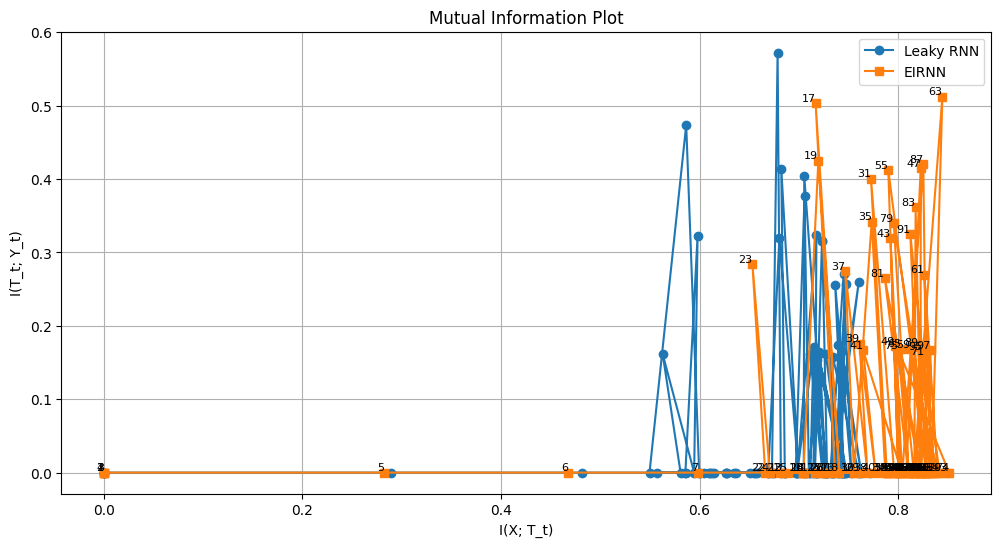

In [51]:
import numpy as np
import matplotlib.pyplot as plt
import warnings

# 忽略字体警告
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")

# 恢复 matplotlib 的默认字体
plt.rcdefaults()
plt.figure(figsize=(12, 6))
# 创建一个图形
# plt.figure(figsize=(10, 8))

# 遍历时间步
I_XT_time_list = []
I_TY_time_list = []
for time_step in range(1, 99, 1):
    # 提取每个时间步的 I(X; T_t) 和 I(T_t; Y_t)
    I_XT_time_list.append([epoch_I_XT[time_step] for epoch_I_XT in I_XT_list])
    I_TY_time_list.append([epoch_I_TY[time_step] for epoch_I_TY in I_TY_list])

# 转为数组
I_XT_time_list = np.vstack(I_XT_time_list)
I_TY_time_list = np.vstack(I_TY_time_list)

# 遍历时间步
I_XT_time_list_lr = []
I_TY_time_list_lr = []
for time_step in range(1, 99, 1):
    # 提取每个时间步的 I(X; T_t) 和 I(T_t; Y_t)
    I_XT_time_list_lr.append([epoch_I_XT[time_step] for epoch_I_XT in I_XT_list_lr])
    I_TY_time_list_lr.append([epoch_I_TY[time_step] for epoch_I_TY in I_TY_list_lr])

# 转为数组
I_XT_time_list_lr = np.vstack(I_XT_time_list_lr)
I_TY_time_list_lr = np.vstack(I_TY_time_list_lr)

# 绘制第 1 条线
plt.plot(
    I_XT_time_list_lr[:, 9],
    I_XT_time_list_lr[:, 9],
    label="Leaky RNN",
    marker="o",  # 圆圈标记
)

# 绘制第 9 条线
plt.plot(
    I_XT_time_list[:, 9],
    I_XT_time_list[:, 9],
    label="EIRNN",
    marker="s",  # 方块标记
)

# 添加数字标记
for idx in range(len(I_XT_time_list[:, 1])):
    plt.text(
        I_XT_time_list[idx, 1],
        I_TY_time_list[idx, 1],
        str(idx + 1),
        fontsize=8,  # 设置字体大小
        ha="right",  # 水平对齐
        va="bottom",  # 垂直对齐
    )

# 设置标签
plt.xlabel("I(X; T_t)")
plt.ylabel("I(T_t; Y_t)")
plt.title("Mutual Information Plot")
plt.legend()  # 添加图例

# 显示图形
plt.grid(True)
plt.show()
